# Volatility basket strategy

- Based on `10-vol-basked-grid-search` 
- Do grid search over the parameter space and display charts to see if we can find "island of stability"

# Set up

Set up Trading Strategy data client.


In [23]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [24]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    id = "10-vol-basked-grid-search"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_1d

    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    categories = ("Meme",)
    
    # Alternative categories
    #categories = {"Artificial Intelligence (AI)"}
    #categories = {"Decentralized Finance (DeFi)"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 8  # How many assets we need in the asset universe to start running the index
    picks_at_the_start_of_month = 8  # At the start of the each month, decide which assets are tradeable each month
    max_assets_in_portfolio = [1, 2, 4, 5, 6, 7, 8, 9]  # How many assets our basket can hold once
    allocation = 0.99  # Allocate all cash to volatile pairs
    minimum_rebalance_trade_threshold = [0.01, 0.1, 0.25]  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 10  # Don't make buys less than this amount
    minimum_volatility_threshold = [-0.02, 0, 0.01, 0.02]  # Set to have Sharpe ratio threshold for the inclusion

    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    rebalance_volalitity_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    rolling_volume_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    min_volume = 1_000_000   # USD
    min_liquidity = 200_000  # USD

    # Exponential moving average length for the volatility
    ann_factor = pd.Timedelta(days=365) / candle_time_bucket.to_pandas_timedelta()
    span = ann_factor
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2024, 8, 15)
    initial_cash = 10_000


parameters = StrategyParameters.from_class(Parameters, grid_search=True) 

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [25]:
import warnings

from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradingstrategy.client import Client
from tradingstrategy.pair import HumanReadableTradingPairDescription
from tradeexecutor.strategy.execution_context import ExecutionMode, ExecutionContext, notebook_execution_context
from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.universe_model import UniverseOptions



#: Assets used as the buy-and-hold benchmark values for our strategy,
#: but not traded by this strategy
BENCHMARK_PAIRS = [
    (ChainId.ethereum, "uniswap-v3", "WBTC", "USDT", 0.0005),
    (ChainId.ethereum, "uniswap-v3", "WETH", "USDC", 0.0005),
]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in BENCHMARK_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Deduplicate trading pairs - Choose the best pair with the best volume
    pairs_df = deduplicate_pairs_by_volume(pairs_df)

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    print("Top pair matches (including benchmark pairs):")
    for _, pair in pairs_df.head(10).iterrows():
        print(f"   Pair: {pair.base_token_symbol} - {pair.quote_token_symbol} ({pair.exchange_slug})")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=False,  # TODO: Currently web API has problems with liquidity for some pairs
        liquidity_time_bucket=TimeBucket.d1,  # Daily liquidity
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48",  # USDC
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark tokens so they can be separated from the rest of the tokens
    # for the index construction
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    return strategy_universe

# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Coingecko universe is <CoingeckoUniverse for 1000 tokens>


load_partial_data() method is designed to load data for low number or trading pairs, got 51 - this might be slow


Total 51 pairs to trade on ethereum for categories ('Meme',)
Top pair matches (including benchmark pairs):
   Pair: WETH - USDC (uniswap-v3)
   Pair: SPX - WETH (uniswap-v2)
   Pair: BITCOIN - WETH (uniswap-v2)
   Pair: Mog - WETH (uniswap-v2)
   Pair: Neiro - WETH (uniswap-v2)
   Pair: MOODENG - WETH (uniswap-v2)
   Pair: PEPE - WETH (uniswap-v2)
   Pair: APU - WETH (uniswap-v2)
   Pair: MAGA - WETH (uniswap-v2)
   Pair: DOGE - WETH (uniswap-v2)


### Asset to trading pair map

- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [26]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Category trading pairs 49
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [27]:
import pandas as pd
import numpy as np
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount


def trailing_sharpe(
    close: pd.Series, 
    window_length_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    vol = returns.rolling(window=window_length_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


def trailing_sharpe_business_month(
    close, 
    window_length_bars: int, 
    span: pd.Timedelta,    
    pair: TradingPairIdentifier, 
    dependency_resolver,
) -> pd.Series:
    """Snap the trailing returns to business month start day/hour."""

    hour = 8  # 8AM

    def first_day_8am(group):
        target_time = group.index[0].floor('D') + pd.Timedelta(hours=hour)
        return group.loc[target_time] if target_time in group.index else np.NaN
        #return group.loc.get(target_time)

    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"window_length_bars": window_length_bars},
    )    

    # TODO: Clean up here?
    # Let's clear this up
    ewm = trailing_sharpe.ewm(span=span).mean()  # Quaterly
    try:
        first_day_series = ewm.resample('MS').apply(first_day_8am)
    except IndexError as e:
        #  IndexError: index 0 is out of bounds for axis 0 with size 0
        print(f"trailing_sharpe_business_month(): Skipping {pair.get_ticker()} because of {e}")
        return pd.Series(dtype=float, index=pd.DatetimeIndex([]))

    # first_day_series.attrs["time_bucket"] = TimeBucket.d30  # Hint this is monthly data
    return first_day_series


def top_pairs_business_month(
    strategy_universe: TradingStrategyUniverse, 
    picks_at_the_start_of_month: int,
    dependency_resolver: IndicatorDependencyResolver,    
) -> pd.Series:
    """Get the pairs that have the best trailing sharpe at the start of the month.
    
    - These are the pairs we will trade

    """

def available_pairs(
    close: pd.Series, 
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Get the available tradeable pairs on each date.

    - Pairs for which have business month trailing sharpe available
    
    - Because the trading universe is only expanding, this number is only going up

    :return:
        Series with pair count for each timestamp    
    """    
    
    series = dependency_resolver.get_indicator_data_pairs_combined("trailing_sharpe_business_month")
    df = series.to_frame(name='value')
    # Convert index: timestamp, (pair_id, value) tuples
    df = df.reset_index(level='pair_id')

    # Remove our benchmark tokens to pollute this number
    df = df[~df["pair_id"].isin(benchmark_pair_ids)]

    # This code groups by the date part of the DatetimeIndex and counts the number of assets for each day.
    return df.groupby(df.index)["pair_id"].nunique()


def volatility(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_std


def rolling_cumulative_volume(volume: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=window_length_bars).sum()
    return rolling_volume


def rolling_liquidity_avg(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=window_length_bars).mean()
    return  rolling_liquidity_close

    
def volume_inclusion_criteria(   
    close: pd.Series, 
    min_volume: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
    pair: TradingPairIdentifier,    
) -> pd.Series:
    """Calculate pair inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    - For each month we pick the N pairs that have the best mohtly trailing sharpe 

    TODO: Add liquidity check later

    :return:
        Series that is True or False whether the pair meets inclusion criteria at any point of time
    """
    series = dependency_resolver.get_indicator_data(
        "rolling_cumulative_volume",
        pair=pair
    )
    mask = series >= min_volume

    # Need to match the DatetimeIndex of trailing_sharpe_business_month
    # for boolean array max() is the same sany()
    monthly_data = mask.resample('MS').max()
    # Because we sample each month month start, the pair is not availabe until the next month
    return monthly_data.shift(-1).fillna(0).astype(int)


def included_pairs(
    close: pd.Series, 
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Included pairs is a combination of available pairs and inclusion criteria.

    - At a given moment of time, which of all available pairs are truly tradeable

    - Pairs for which have business month trailing sharpe available
    
    - Pairs that meet the inclusion criteria

    :return:
        Series with pair count for each timestamp
    """    
    
    series = dependency_resolver.get_indicator_data_pairs_combined("volume_inclusion_criteria")

    # Drop all False values (pair was not included)
    series = series.loc[series == True]

    df = series.to_frame(name='value')
    # Convert index: timestamp, (pair_id, value) tuples
    df = df.reset_index(level='pair_id')

    # Remove our benchmark tokens to pollute this number
    df = df[~df["pair_id"].isin(benchmark_pair_ids)]

    # This code groups by the date part of the DatetimeIndex and counts the number of assets for each day.
    return df.groupby(df.index)["pair_id"].nunique()
    

def monthly_traded_pairs(   
    strategy_universe: TradingStrategyUniverse, 
    picks_at_the_start_of_month: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """For each month, get the list of the pairs we will trade.
    
    - This series can be exploded and forward filled to get hourly boolean mask
    
    :return:
       Monthly Pandas series with (pair_id, timestamp) index that contains sharpe values only for top picks of that month.

       The value of the series is monthly trailing sharpe for the pair.
    """

    # Get trailing sharepe for all pairs as (pair_id, timestamp) indexed series
    df = pd.DataFrame({
        "trailing_sharpe_business_month": dependency_resolver.get_indicator_data_pairs_combined("trailing_sharpe_business_month"),
        "volume_inclusion_criteria": dependency_resolver.get_indicator_data_pairs_combined("volume_inclusion_criteria"),
    })

    # Remove assets that are not part of the category,
    # and are only included for benchmark or currency conversion purposes
    df =  df[~df.index.get_level_values('pair_id').isin(benchmark_pair_ids)]
    
    # Drop pairs that do not meet volume inclusion criteria, and leave the sharpes left 
    # for the pairs that do meet the criteria
    df["filtered_sharpe"] = df["trailing_sharpe_business_month"].loc[df["volume_inclusion_criteria"] == True]

    top_picks = df["filtered_sharpe"].groupby('timestamp').nlargest(picks_at_the_start_of_month)
    
    # MultiIndex is now (timestamp, pair_id, timestamp) -> fix it
    top_picks = top_picks.droplevel(0)

    """
    pair_id  timestamp 
    36926    2022-08-01          NaN
    37316    2022-08-01          NaN
    52587    2022-08-01          NaN
    68900    2022-08-01          NaN
    36926    2022-09-01          NaN
    37316    2022-09-01          NaN
    52587    2022-09-01          NaN
    68900    2022-09-01          NaN
    2701164  2022-10-01     2.788998
    2711945  2022-10-01    -0.039353
    """
    
    return top_picks
    

def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    """Create indicator descriptions.
    
    - Indicators are automatically recalculated and cached by the backtest runner,
      if indicator Python function body or parameters change
    """
    indicator_set = IndicatorSet()
    indicator_set.add(
        "trailing_sharpe",
        trailing_sharpe,
        {"window_length_bars": parameters.trailing_sharpe_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "volatility",
        volatility,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "rolling_cumulative_volume",
        rolling_cumulative_volume,
        {"window_length_bars": parameters.rolling_volume_bars},
        IndicatorSource.ohlcv,
    )    
    # TODO: Currently web API issues loading this data for certain pairs
    #
    # indicator_set.add(
    #     "rolling_liquidity_avg",
    #     rolling_liquidity_avg,
    #     {"window_length_bars": parameters.rolling_liquidity_bars,
    #     IndicatorSource.liquidity,
    # )        
    indicator_set.add(
        "trailing_sharpe_business_month",
        trailing_sharpe_business_month,
        {"window_length_bars": parameters.trailing_sharpe_bars, "span": parameters.span},
        IndicatorSource.close_price,
        order=2,  # After trailing_sharpe
    )    
    indicator_set.add(
        "available_pairs",
        available_pairs,  
        {},  
        IndicatorSource.strategy_universe,
        order=3,  # After trailing_sharpe_business_month
    )       
    indicator_set.add(
        "volume_inclusion_criteria",
        volume_inclusion_criteria,  
        {"min_volume": parameters.min_volume},  
        IndicatorSource.ohlcv,
        order=3,  
    )       

    
    indicator_set.add(
        "included_pairs",
        included_pairs,  
        {},
        IndicatorSource.strategy_universe,
        order=4,  
    )       

    indicator_set.add(
        "monthly_traded_pairs",
        monthly_traded_pairs,  
        {
            "picks_at_the_start_of_month": parameters.picks_at_the_start_of_month,
        },  
        IndicatorSource.strategy_universe,
        order=5,  
    )       

    return indicator_set


# Strategy algorithm and backtest

- Run the backtest

In [28]:
from tradingstrategy.types import PrimaryKey

from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.weighting import weight_by_1_slash_signal
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline


#: Cache for monthly traded pairs
_monthly_cached_pairs: dict[pd.Timestamp, list[PrimaryKey]] = {}


def get_monthly_traded_pairs(
    timestamp: pd.Timestamp,
    monthly_traded_pairs: pd.Series,
) -> list[PrimaryKey]:
    # Speeded up version to get pairs we trade each month
    month_start = timestamp.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

    if month_start not in _monthly_cached_pairs:        
        pair_ids = monthly_traded_pairs.xs(month_start, level='timestamp').index.unique()
        _monthly_cached_pairs[month_start]  = list(pair_ids)

    return _monthly_cached_pairs[month_start]


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Resolve pairs we have in the currently tradeable set
    monthly_traded_pairs = indicators.get_indicator_series(
        "monthly_traded_pairs",
        unlimited=True,
    )
    pair_ids = get_monthly_traded_pairs(timestamp, monthly_traded_pairs)

    if len(pair_ids) > parameters.min_asset_universe:
        state.mark_ready(timestamp)

    # Build signals for each pair 
    alpha_model = AlphaModel(timestamp)
    for pair_id in pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)

        volatility = indicators.get_indicator_value("volatility", pair=pair)
        if volatility is None:
            # Back buffer has not filled up yet with enough data,
            # skip to the next pair
            continue

        if volatility >= parameters.minimum_volatility_threshold:
            # Include this pair for the ranking for each tick
            alpha_model.set_signal(
                pair,
                volatility,
            )

        # Our trading starts as soon as we have valid
        # data for at least the one trading pair
        # state.mark_ready(timestamp)

   # Select max_assets_in_portfolio assets in which we are going to invest
    alpha_model.select_top_signals(parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_by_1_slash_signal)
    alpha_model.normalise_weights()

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(state.portfolio)

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals if the basket value mixture changes
    # more than rebalance_threshold_usd USD
    rebalance_threshold_usd = state.portfolio.get_total_equity() * parameters.minimum_rebalance_trade_threshold
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
    )

    if input.is_visualisation_enabled():
        # Save alpha model debug data to diagnose the strategy
        # (Only when not grid search/optimiser)
        # SLOW
        # state.visualisation.add_calculations(timestamp, alpha_model.to_dict())
        pass

    return trades  # Return the list of trades we made in this cycle


# Run grid search

In [29]:
from tradeexecutor.backtest.grid_search import GridCombination, get_grid_search_result_path, perform_grid_search, prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = get_grid_search_result_path(Parameters.id)

# Popular grid search combinations and indicators for them
combinations = prepare_grid_combinations(
    parameters,
    storage_folder,
    create_indicators=create_indicators,
    strategy_universe=strategy_universe,
)

indicators = GridCombination.get_all_indicators(combinations)

print(f"We prepared {len(combinations)} grid search combinations with total {len(indicators)} indicators which need to be calculated, stored in {storage_folder.resolve()}")

grid_search_results = perform_grid_search(
    decide_trades,
    strategy_universe,
    combinations,
    trading_strategy_engine_version="0.5",
    multiprocess=True,
)


We prepared 96 grid search combinations with total 258 indicators which need to be calculated, stored in /Users/moo/.cache/tradingstrategy/grid-search/10-vol-basked-grid-search
Using indicator cac he /Users/moo/.cache/indicators/ethereum_1h_51_2022-08-15-2024-08-15_ff
Using grid search cache /Users/moo/.cache/tradingstrategy/grid-search/10-vol-basked-grid-search, for indicators max_assets_in_portfolio, minimum_rebalance_trade_threshold, minimum_volatility_threshold


Reading cached search results w/ 10 threads:   0%|          | 0/96 [00:00<?, ?it/s]

All results were cached, grid search skipped


# Search results

In [30]:
from tradeexecutor.analysis.grid_search import find_best_grid_search_results
# from tradeexecutor.analysis.grid_search import visualise_table

# Print extension of our backtest
cached_results = [r for r in grid_search_results if r.cached]
print(f"Grid search results available: {len(grid_search_results)}, of which we got cached {len(cached_results)} in {storage_folder}")


Grid search results available: 96, of which we got cached 96 in /Users/moo/.cache/tradingstrategy/grid-search/10-vol-basked-grid-search


## All results

- Show all results in a single table

In [31]:
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import render_grid_search_result_table

df = analyse_grid_search_result(grid_search_results)
print(f"We have valid {len(df)} grid search results total, out from {len(grid_search_results)}")

if len(df) < 100:
    render_grid_search_result_table(df)
else:
    print("Too many grid search results to render in a single table")



We have valid 86 grid search results total, out from 96


# Highest CAGR - top pick table

- List of strategy parameter candidates
- From all grid search results, sorted by CAGR (profitability)

In [32]:
from tradeexecutor.analysis.grid_search import find_best_grid_search_results, render_grid_search_result_table

best_results = find_best_grid_search_results(grid_search_results)
render_grid_search_result_table(best_results.cagr)

# Trailing sharpe visualisation



In [33]:
sharpe_lookback = pd.Timedelta("180d") 

## Sharpe as a heatmap for two parameters

/Users/moo/code/trade-executor/tradeexecutor/visual/grid_search_advanced.py:134: RuntimeWarning:

invalid value encountered in scalar divide



1                                       2            \
               -0.02      0.00      0.01      0.02     -0.02      0.00   
2022-10-01 -1.675578 -1.510501 -1.675578 -2.021164 -1.832796 -0.012141   
2022-11-01 -1.268775 -1.131499 -1.268775  2.310575 -1.922647 -0.979196   
2022-12-01 -1.508047 -1.500643 -1.508047  0.621358 -1.383785 -1.055322   
2023-01-01 -1.592575 -1.589632 -1.474268  0.961815 -1.681238 -1.409403   
2023-02-01 -0.847005 -0.831945  0.625696  2.720478  0.416571 -0.446806   

                                       4            ...         7            \
                0.01      0.02     -0.02      0.00  ...      0.01      0.02   
2022-10-01 -1.832796 -2.021164 -1.886570 -0.682959  ...       NaN -2.021164   
2022-11-01  0.105540  2.310575 -1.187844 -0.535452  ...  3.196674  2.310575   
2022-12-01 -0.517221  0.440669 -0.707757 -0.318497  ...  1.167880  0.540817   
2023-01-01 -0.830085  0.864386 -1.491304 -1.192996  ...  0.499171  0.917575   
2023-02-01  0.552099  2.666179  0.724354  0.996729  ...  1.968970  2.694336   

               8                               9                            
           -0.02  0.00      0.01      0.02 -0.02  0.00      0.01      0.02  
2022-10-01   NaN   NaN       NaN -2.021164   NaN   NaN       NaN -2.021164  
2022-11-01   NaN   NaN  3.196674  2.310575   NaN   NaN  3.196674  2.310575  
2022-12-01   NaN   NaN  1.157711  0.540817   NaN   NaN  1.157711  0.540817  
2023-01-01   NaN   NaN  0.501012  0.917575   NaN   NaN  0.501012  0.917575  
2023-02-01   NaN   NaN  1.834172  2.694336   NaN   NaN  1.834172  2.694336  

[5 rows x 32 columns]

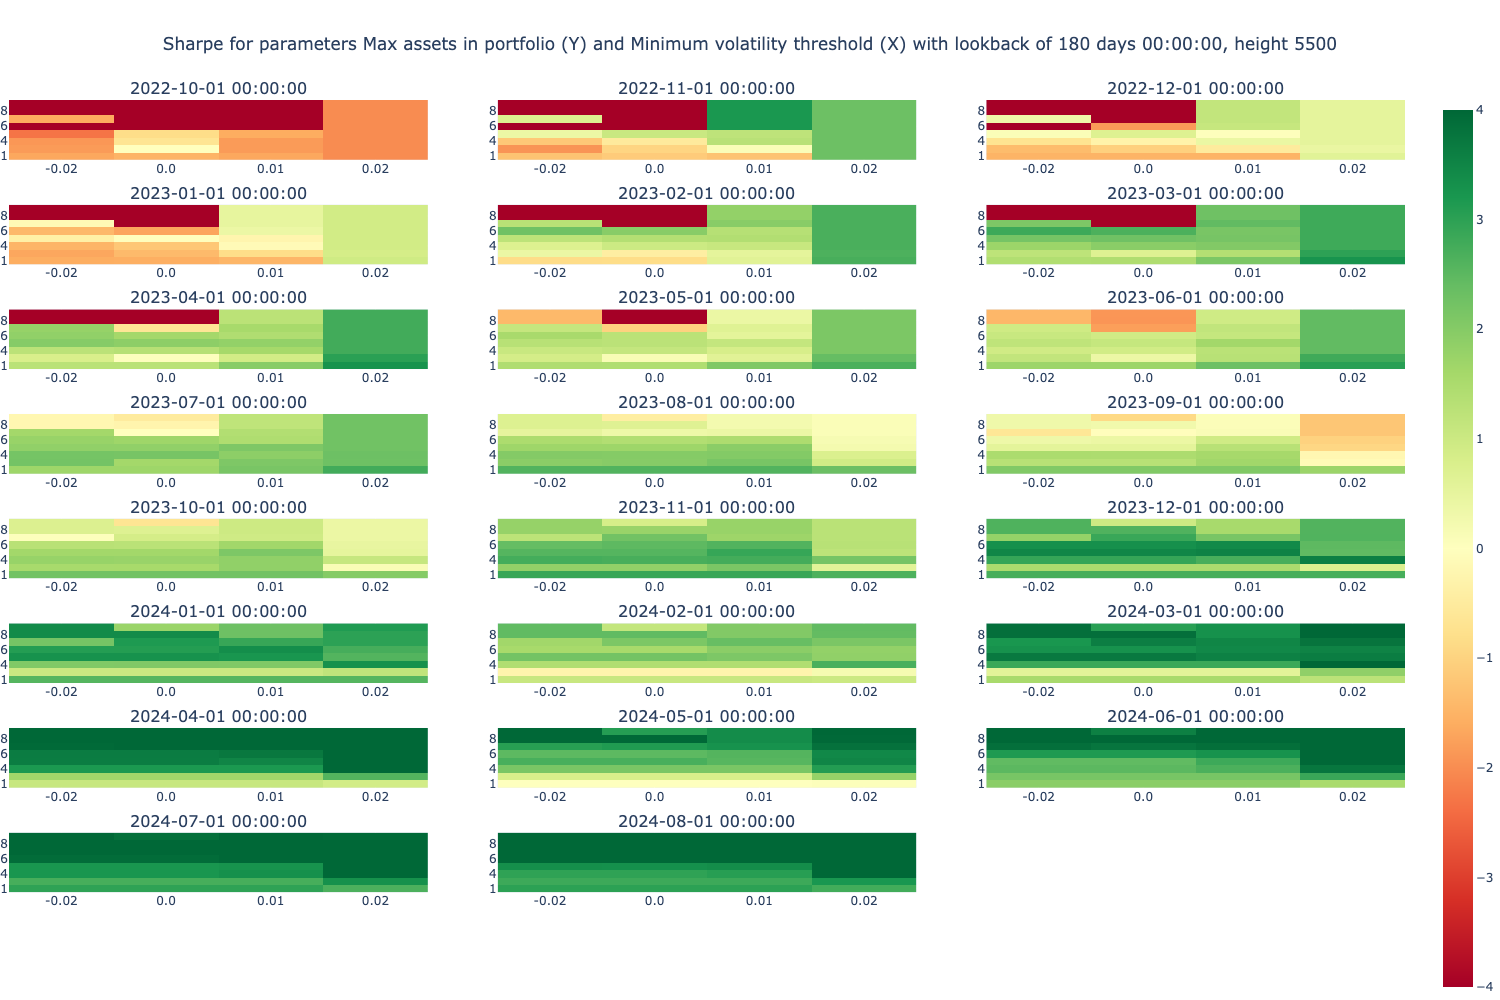

In [34]:
from tradeexecutor.visual.grid_search_advanced import calculate_rolling_metrics
from tradeexecutor.visual.grid_search_advanced import visualise_grid_rolling_metric_heatmap
from tradeexecutor.visual.grid_search_advanced import BenchmarkMetric

metrics_df = calculate_rolling_metrics(
    grid_search_results,
    sample_freq="MS",  # Month start
    lookback=sharpe_lookback,
    visualised_parameters=("max_assets_in_portfolio", "minimum_volatility_threshold"),
    benchmarked_metric=BenchmarkMetric.sharpe,
    fixed_parameters={
        "picks_at_the_start_of_month": 8,
        "minimum_rebalance_trade_threshold": 0.25,        
    }
)

display(metrics_df.head())

fig = visualise_grid_rolling_metric_heatmap(
    metrics_df,
    scale=(-4, 4),
    width=500,
    height_per_row=600,
)

display(fig)


## Sharpe for a max assets in portfolio as series of charts

/Users/moo/code/trade-executor/tradeexecutor/visual/grid_search_advanced.py:134: RuntimeWarning:

invalid value encountered in scalar divide



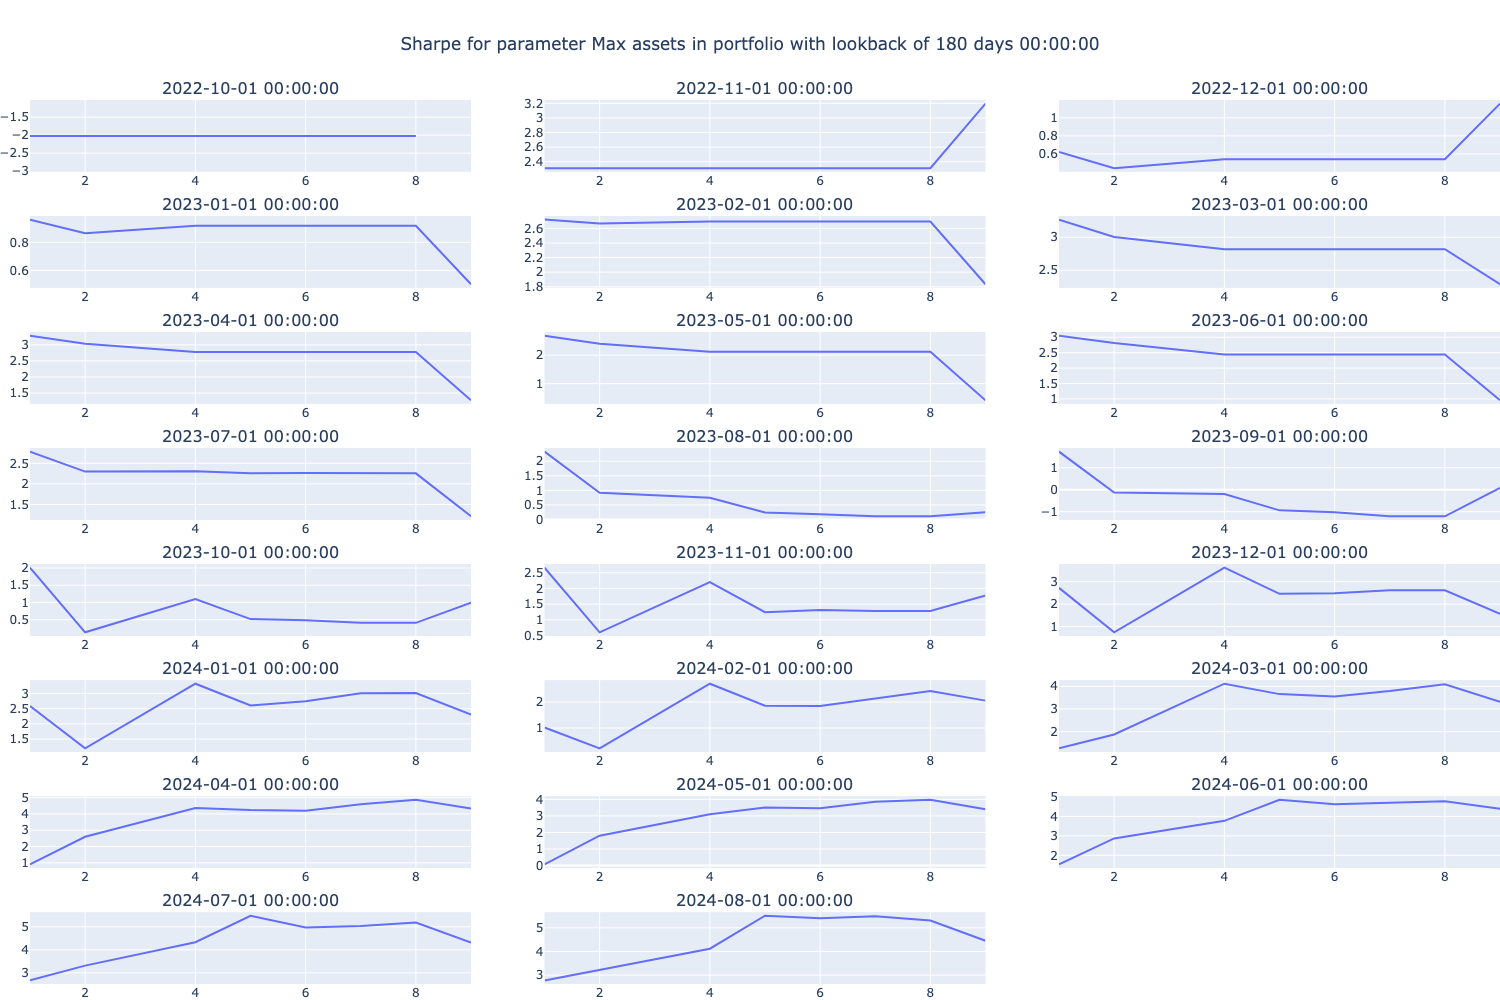

In [35]:
from tradeexecutor.visual.grid_search_advanced import calculate_rolling_metrics
from tradeexecutor.visual.grid_search_advanced import visualise_grid_rolling_metric_line_chart
from tradeexecutor.visual.grid_search_advanced import BenchmarkMetric

metrics_df = calculate_rolling_metrics(
    grid_search_results,
    sample_freq="MS",  # Month start
    lookback=sharpe_lookback,
    visualised_parameters="max_assets_in_portfolio",
    benchmarked_metric=BenchmarkMetric.sharpe,
    fixed_parameters={
        "picks_at_the_start_of_month": 8,
        "minimum_volatility_threshold": 0.02,
        "minimum_rebalance_trade_threshold": 0.25,        
    }
)

fig = visualise_grid_rolling_metric_line_chart(
    metrics_df,
)
display(fig)


## Sharpe for a volatility threshold in portfolio as series of charts

/Users/moo/code/trade-executor/tradeexecutor/visual/grid_search_advanced.py:134: RuntimeWarning:

invalid value encountered in scalar divide



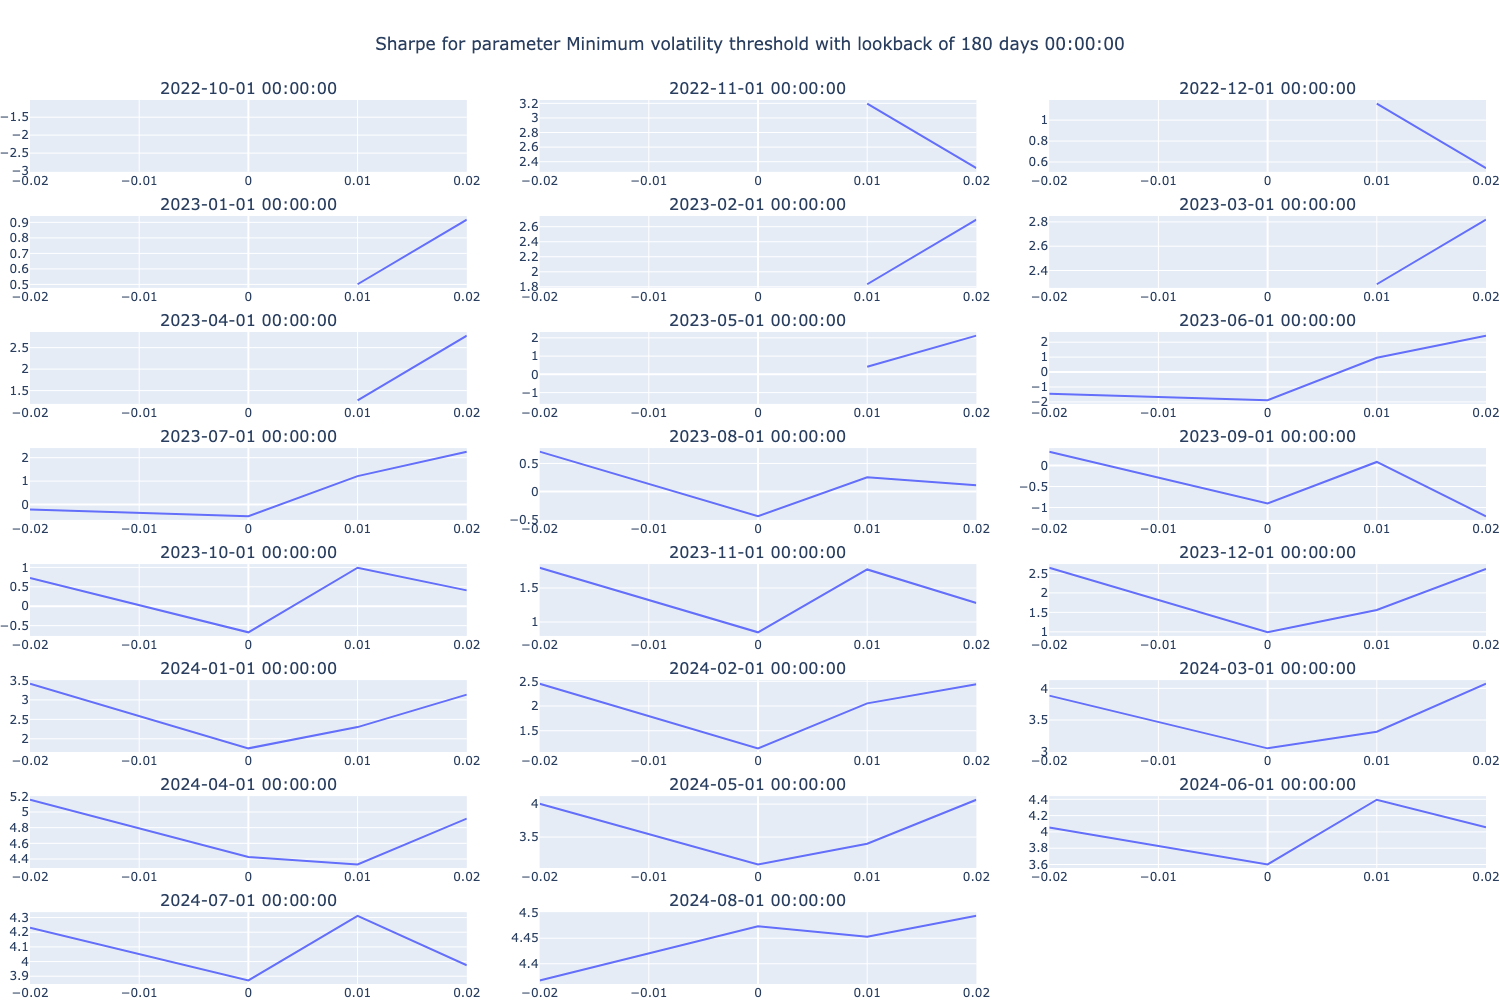

In [36]:
from tradeexecutor.visual.grid_search_advanced import calculate_rolling_metrics
from tradeexecutor.visual.grid_search_advanced import visualise_grid_rolling_metric_line_chart
from tradeexecutor.visual.grid_search_advanced import BenchmarkMetric

metrics_df = calculate_rolling_metrics(
    grid_search_results,
    sample_freq="MS",  # Month start
    lookback=sharpe_lookback,
    visualised_parameters="minimum_volatility_threshold",
    benchmarked_metric=BenchmarkMetric.sharpe,
    fixed_parameters={
        "picks_at_the_start_of_month": 8,
        "max_assets_in_portfolio": 8,
        "minimum_rebalance_trade_threshold": 0.25,        
    }
)

fig = visualise_grid_rolling_metric_line_chart(
    metrics_df,
)
display(fig)


## Sharpe comparison for allocation

- Compare Sharpe rations evoluation of different parameters over time

/Users/moo/code/trade-executor/tradeexecutor/visual/grid_search_advanced.py:134: RuntimeWarning:

invalid value encountered in scalar divide



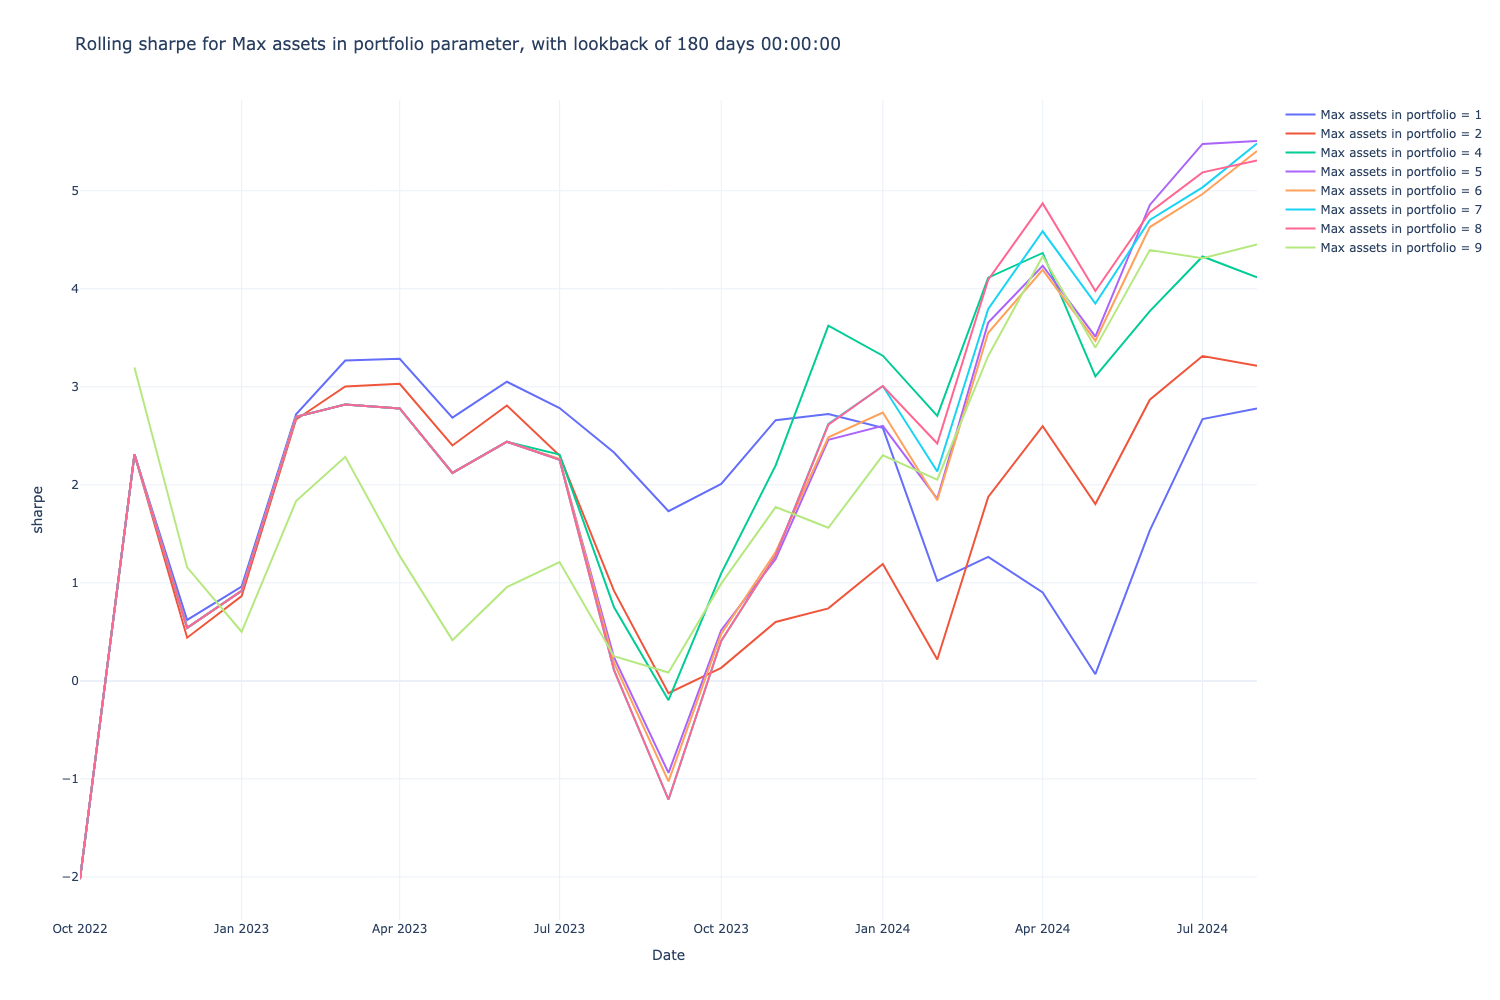

In [37]:
from tradeexecutor.visual.grid_search_advanced import calculate_rolling_metrics
from tradeexecutor.visual.grid_search_advanced import visualise_grid_single_rolling_metric
from tradeexecutor.visual.grid_search_advanced import BenchmarkMetric

metrics_df = calculate_rolling_metrics(
    grid_search_results,
    sample_freq="MS",  # Month start
    lookback=sharpe_lookback,
    visualised_parameters="max_assets_in_portfolio",
    benchmarked_metric=BenchmarkMetric.sharpe,
    fixed_parameters={
        "picks_at_the_start_of_month": 8,
        "minimum_volatility_threshold": 0.02,
        "minimum_rebalance_trade_threshold": 0.25,        
    }
)

fig = visualise_grid_single_rolling_metric(metrics_df)
display(fig)

## Sharpe comparison by minimum_rebalance_trade_threshold parameter

/Users/moo/code/trade-executor/tradeexecutor/visual/grid_search_advanced.py:134: RuntimeWarning:

invalid value encountered in scalar divide



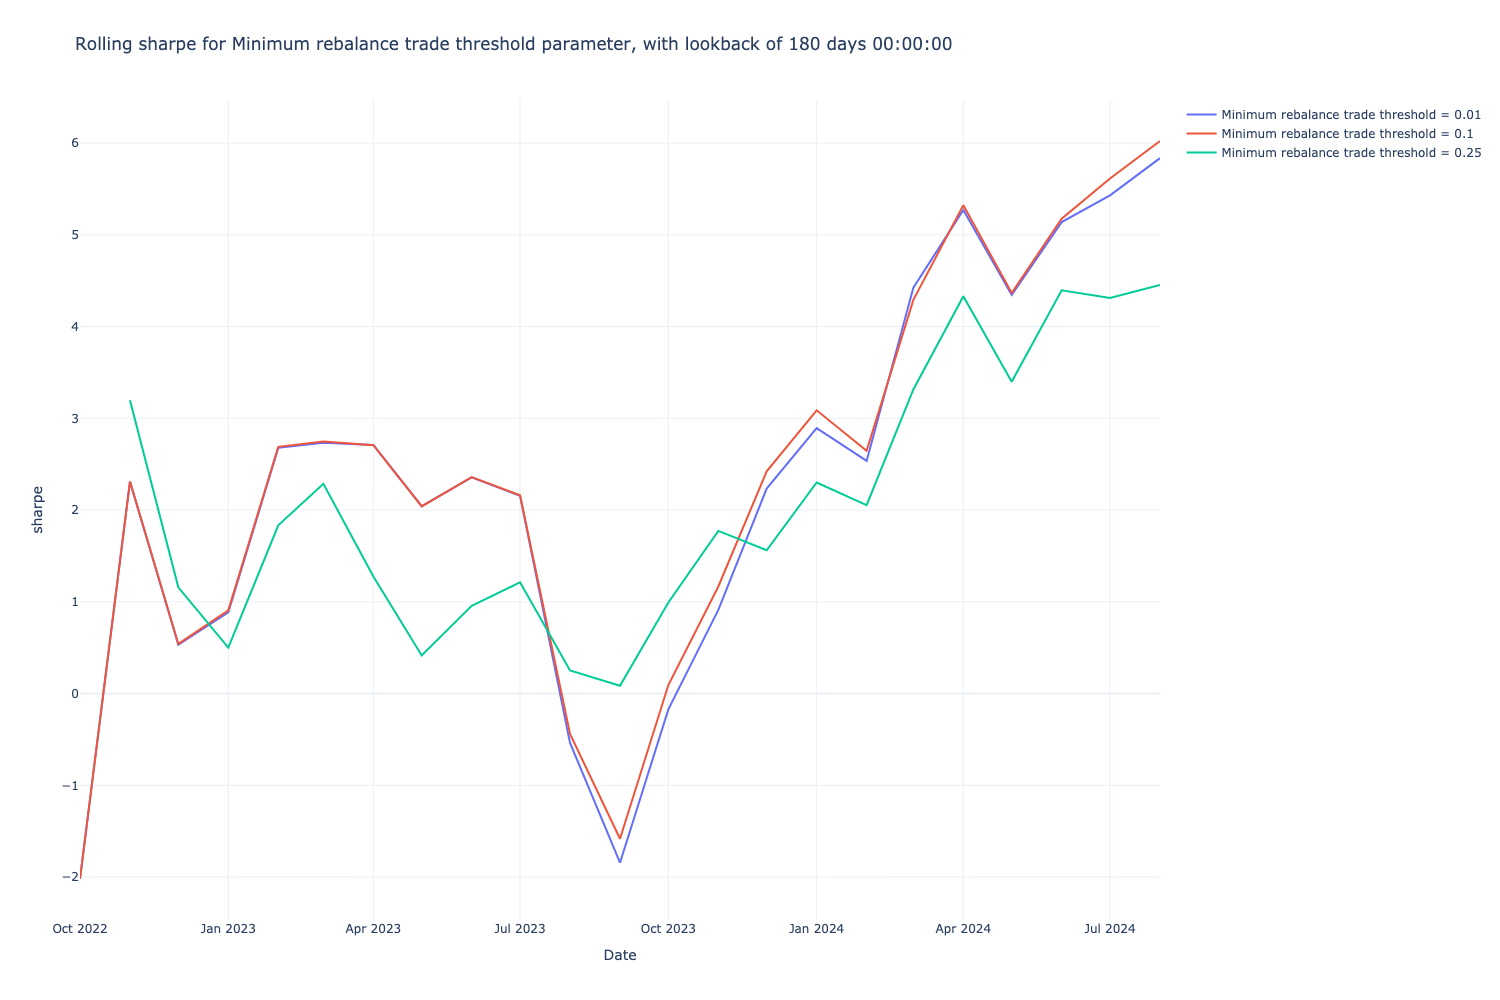

In [38]:
from tradeexecutor.visual.grid_search_advanced import calculate_rolling_metrics
from tradeexecutor.visual.grid_search_advanced import visualise_grid_single_rolling_metric
from tradeexecutor.visual.grid_search_advanced import BenchmarkMetric

metrics_df = calculate_rolling_metrics(
    grid_search_results,
    sample_freq="MS",  # Month start
    lookback=sharpe_lookback,
    visualised_parameters="minimum_rebalance_trade_threshold",
    benchmarked_metric=BenchmarkMetric.sharpe,
    fixed_parameters={
        "max_assets_in_portfolio": 6,
        "minimum_volatility_threshold": 0.02,
        "picks_at_the_start_of_month": 4,
    }
)

fig = visualise_grid_single_rolling_metric(metrics_df)
display(fig)

## Sharpe comparison by picks_at_the_start_of_month parameter

/Users/moo/code/trade-executor/tradeexecutor/visual/grid_search_advanced.py:134: RuntimeWarning:

invalid value encountered in scalar divide



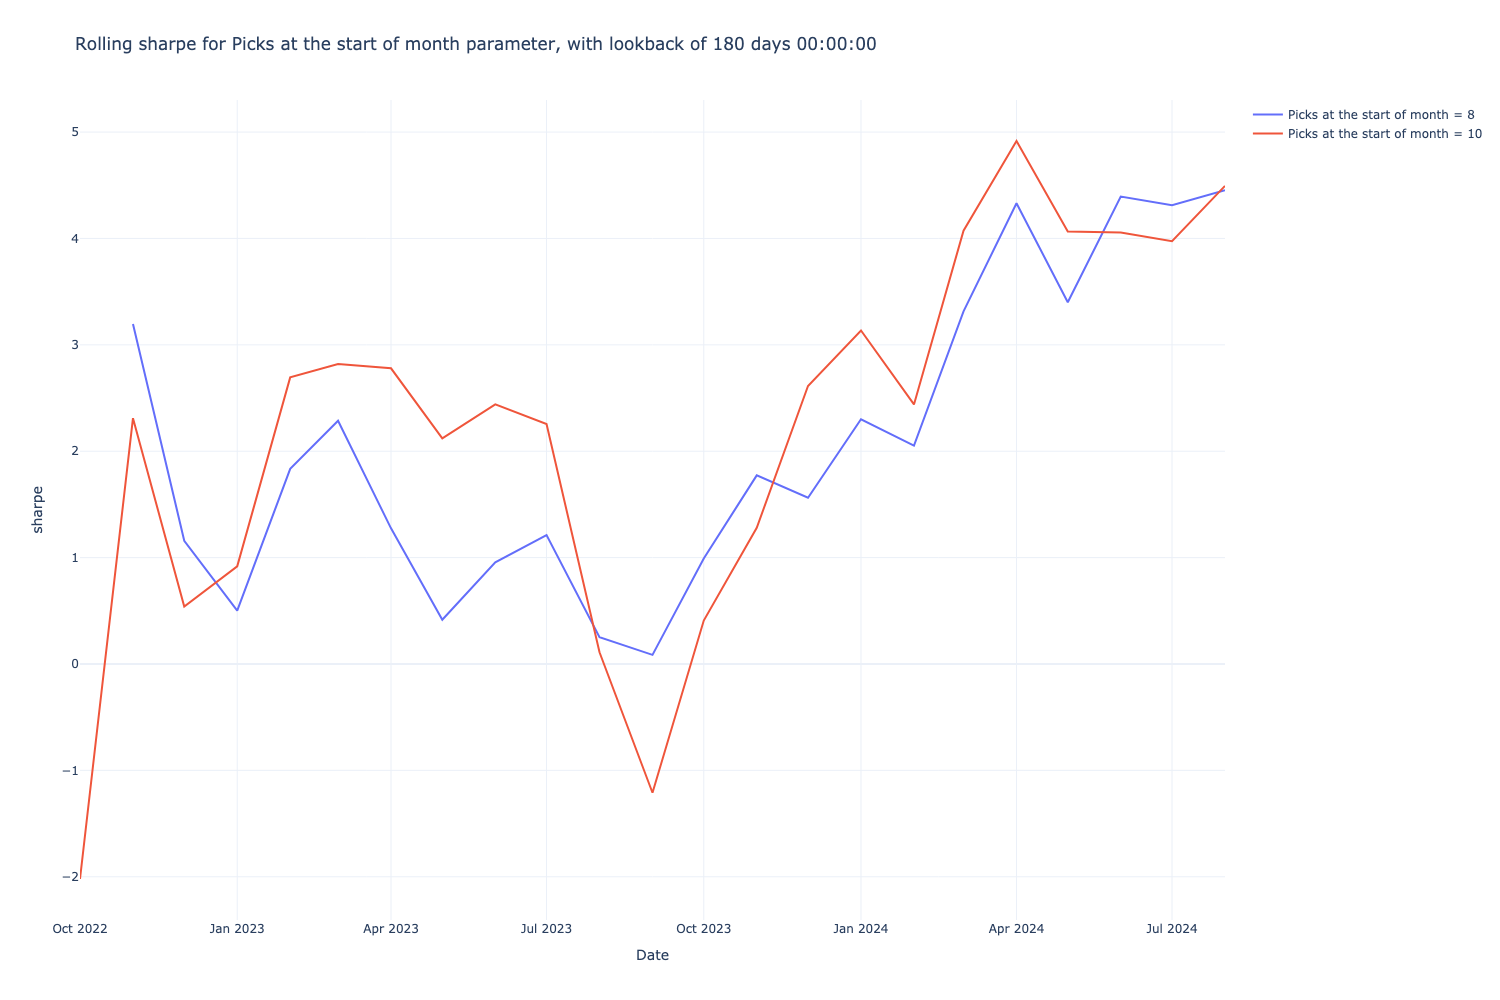

In [39]:
from tradeexecutor.visual.grid_search_advanced import calculate_rolling_metrics
from tradeexecutor.visual.grid_search_advanced import visualise_grid_single_rolling_metric
from tradeexecutor.visual.grid_search_advanced import BenchmarkMetric

metrics_df = calculate_rolling_metrics(
    grid_search_results,
    sample_freq="MS",  # Month start
    lookback=sharpe_lookback,
    visualised_parameters="picks_at_the_start_of_month",
    benchmarked_metric=BenchmarkMetric.sharpe,
    fixed_parameters={
        "max_assets_in_portfolio": 6,
        "minimum_volatility_threshold": 0.02,
        "minimum_rebalance_trade_threshold": 0.25,        
    }
)

fig = visualise_grid_single_rolling_metric(metrics_df)
display(fig)

## Equity curves

- Show equity curves of the top result
- Logarithmic curve

The CARG optimised best candidate equity curve.

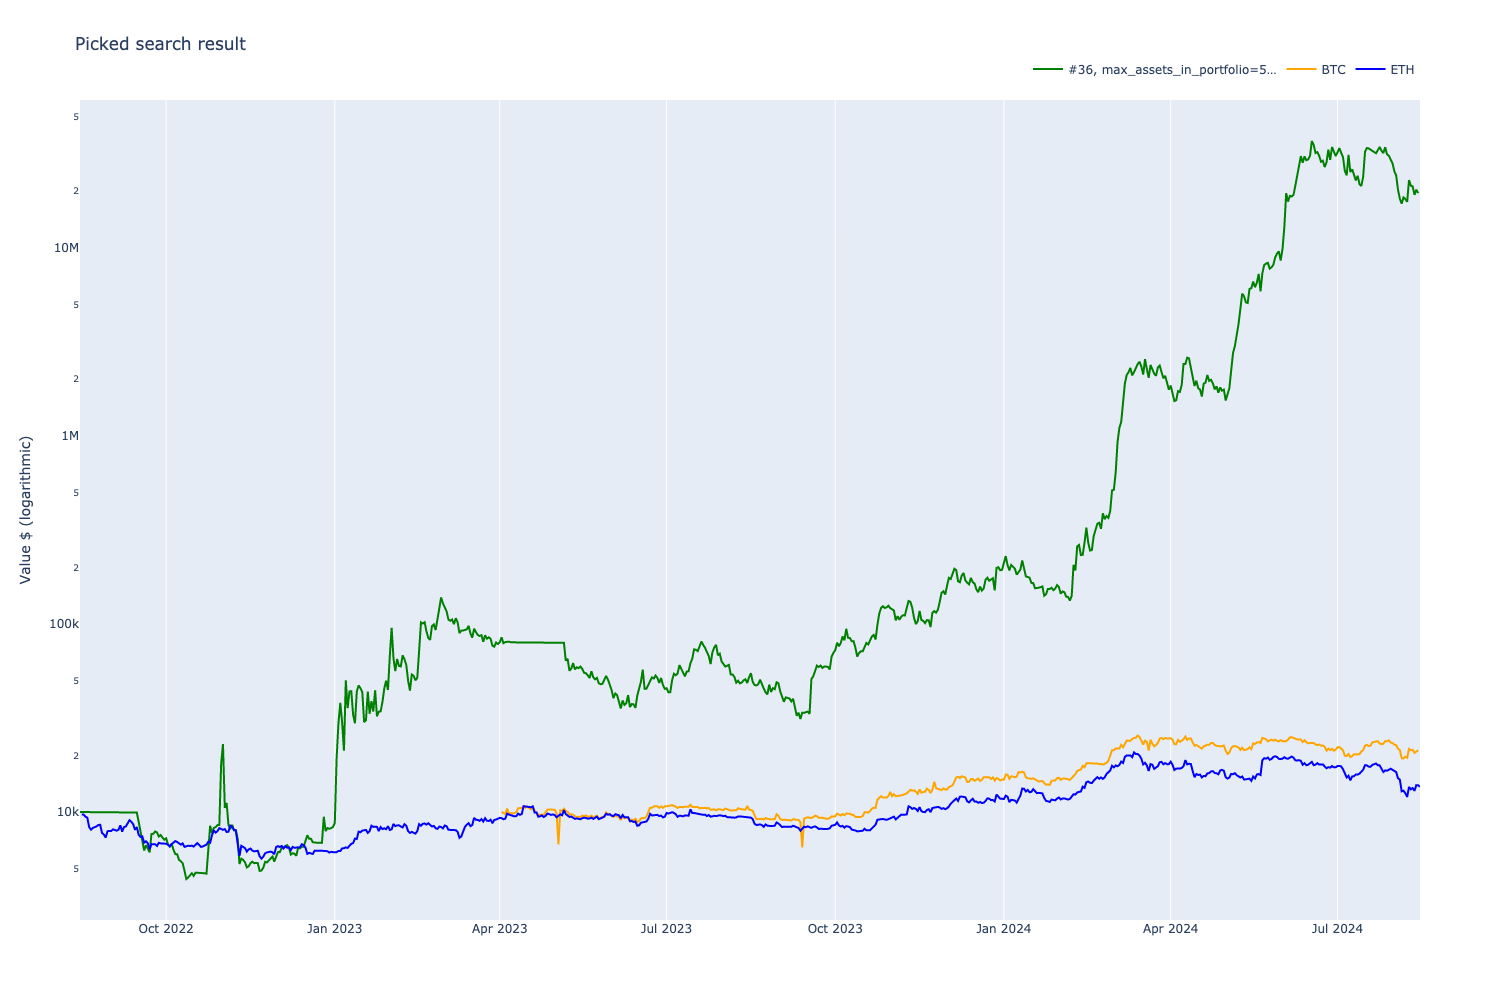

In [40]:
from tradeexecutor.visual.grid_search import visualise_single_grid_search_result_benchmark

fig = visualise_single_grid_search_result_benchmark(
    best_results.cagr[0], 
    strategy_universe, 
    initial_cash=Parameters.initial_cash,
    log_y=True,
)
fig.show()

### Equity curve with max drawdown

- Alternative equity curve visualisation and inspection
- Linear - not logarithmic scale

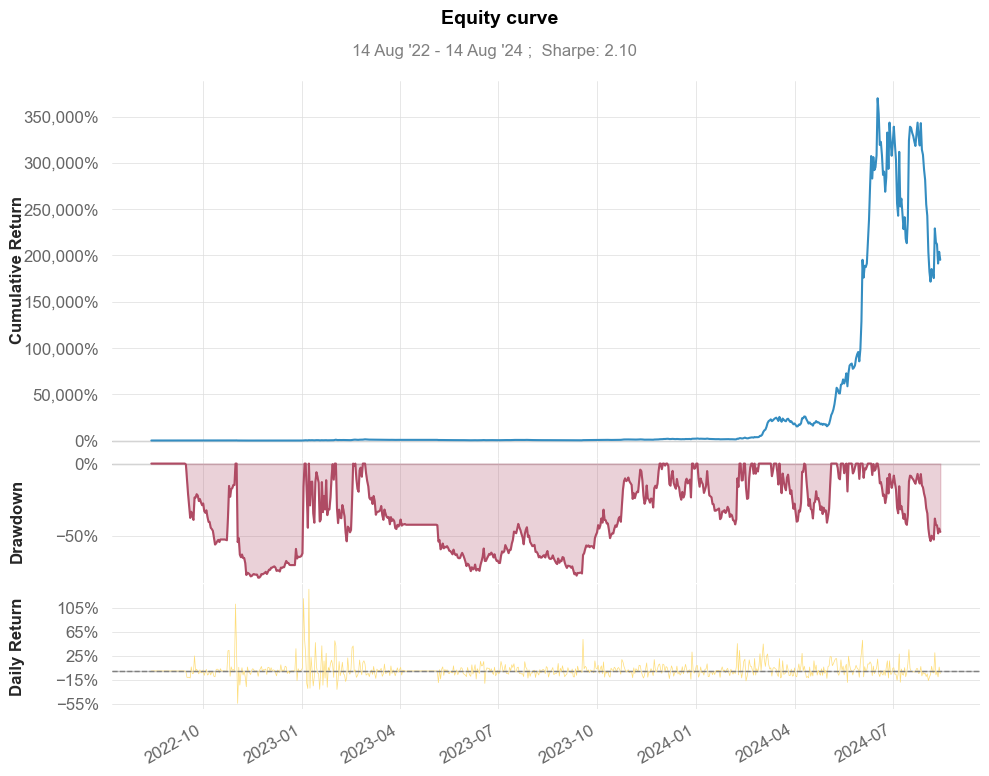

In [41]:
from tradeexecutor.visual.equity_curve import visualise_equity_curve

fig = visualise_equity_curve(
    best_results.cagr[0].returns,
)
display(fig)

## Highest Sharpe - top picks table

- List of strategy parameter candidates
- From all grid search results, sorted by Sharpe (risk-adjusted profit)

In [42]:
render_grid_search_result_table(best_results.sharpe)

The optimised Sharpe result equity curve

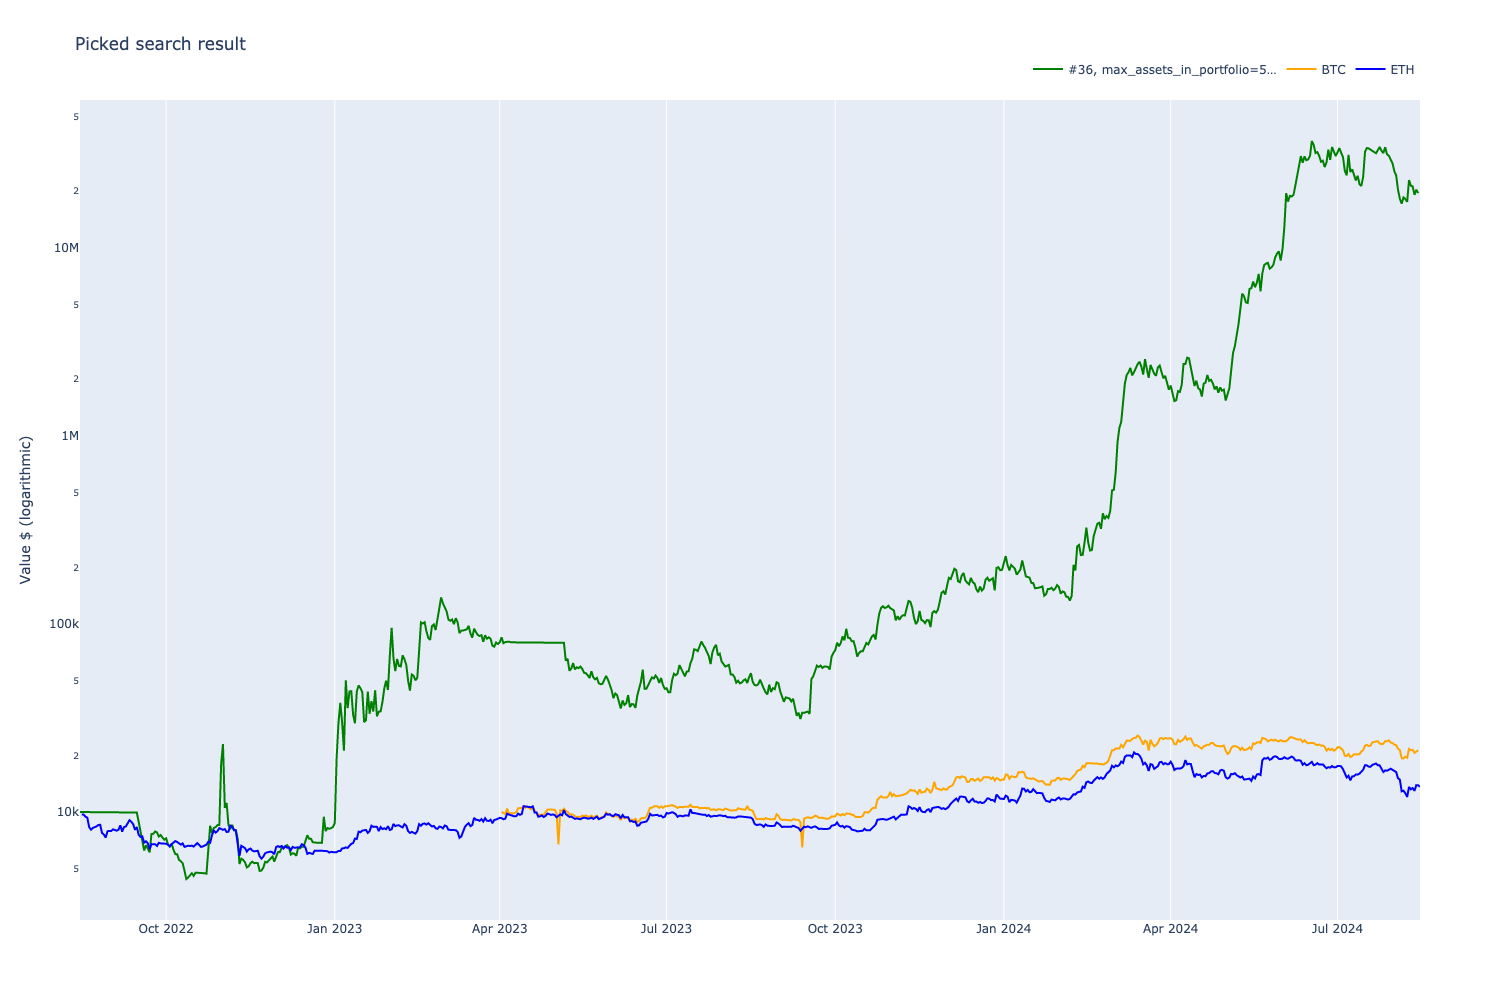

In [43]:
fig = visualise_single_grid_search_result_benchmark(
    best_results.sharpe[0], 
    strategy_universe, 
    initial_cash=Parameters.initial_cash,
    log_y=True,
)
fig.show()